In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as pe
from matplotlib.ticker import FormatStrFormatter

import corner

import utils

In [2]:
Res_A = utils.RetrievalResults(
    prefix='../retrieval_outputs/new_fiducial_K_A_ret_10/test_', 
    #prefix='../retrieval_outputs/new_fiducial_K_A_ret_3/test_', 
    m_set='K2166_A', w_set='K2166', load_posterior=True
    )
Res_B = utils.RetrievalResults(
    prefix='../retrieval_outputs/new_fiducial_K_B_ret_5/test_', 
    #prefix='../retrieval_outputs/new_fiducial_K_B_ret_3/test_', 
    m_set='K2166_B', w_set='K2166', load_posterior=True
    )

Chem_A = Res_A._load_object('Chem')
Chem_B = Res_B._load_object('Chem')

  analysing data from ../retrieval_outputs/new_fiducial_K_A_ret_10/test_.txt
['modes', 'nested sampling global log-evidence', 'nested sampling global log-evidence error', 'global evidence', 'global evidence error', 'nested importance sampling global log-evidence', 'nested importance sampling global log-evidence error', 'marginals']
999842.8530926444
977809.465665599
977809.465665599
  analysing data from ../retrieval_outputs/new_fiducial_K_B_ret_5/test_.txt
['modes', 'nested sampling global log-evidence', 'nested sampling global log-evidence error', 'global evidence', 'global evidence error', 'nested importance sampling global log-evidence', 'nested importance sampling global log-evidence error', 'marginals']
1008102.1030179668
1008072.4699441883
1008072.4699441883


In [3]:
name_A = 'Luhman 16A'; name_B = 'Luhman 16B'
color_m_A = '#FF622E'; color_m_B = '#396ED8'

lw_d = 0.8; lw_m = 1.0

cmap_m_A = mpl.colors.LinearSegmentedColormap.from_list('', ['w',color_m_A])
env_colors_m_A = cmap_m_A([0.4,0.6,0.8])
env_colors_m_A[:,3] = 0.5

cmap_m_B = mpl.colors.LinearSegmentedColormap.from_list('', ['w',color_m_B])
env_colors_m_B = cmap_m_B([0.4,0.6,0.8])
env_colors_m_B[:,3] = 0.5

color_species = {
    'HF':'#FF59B4', '12CO':'C2', 'H2O':'C3', 'NH3':'C8', 'CH4':'C4', 'H2S':'#135D64', 
    'Na':'C1', 'K':'C0', 'FeH':'#00DBA8',
    }

In [4]:
def get_chem_ratios(VMR):
    
    chem_ratios = {}
    #chem_ratios['C/O'] = VMR['12CO'] / (VMR['12CO']+VMR['H2O'])
    chem_ratios['C/O'] = (VMR['12CO']+VMR['CH4']) / (VMR['12CO']+VMR['H2O'])
    chem_ratios['12CO/13CO'] = VMR['12CO'] / VMR['13CO']
    chem_ratios['C16O/C18O'] = VMR['12CO'] / VMR['C18O']
    chem_ratios['H2(16)O/H2(18)O'] = VMR['H2O'] / VMR['H2(18)O']

    return chem_ratios

VMR_posterior_A = utils.convert_mf_dict_to_VMR_dict(Chem_A, relative_to_key=None)
VMR_posterior_B = utils.convert_mf_dict_to_VMR_dict(Chem_B, relative_to_key=None)

chem_ratios_A = get_chem_ratios(VMR_posterior_A)
chem_ratios_B = get_chem_ratios(VMR_posterior_B)

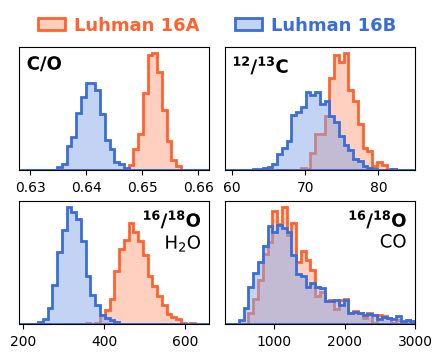

In [5]:
fig = plt.figure(figsize=(4.5,3.6))
gs = fig.add_gridspec(
    nrows=2, ncols=2, hspace=0.25, wspace=0.08, 
)
ax_CO = fig.add_subplot(gs[0,0])
ax_13C = fig.add_subplot(gs[0,1])
ax_18O = fig.add_subplot(gs[1,0])
ax_C18O = fig.add_subplot(gs[1,1], zorder=-1)

hist_kwargs_A = dict(
    #bins=25, histtype='stepfilled', fc=env_colors_m_A[1], ec=color_m_A, lw=2, bottom=0, density=True
    bins=40, histtype='stepfilled', fc=env_colors_m_A[1], ec=color_m_A, lw=2, bottom=0, density=True
)

hist_kwargs_B = hist_kwargs_A.copy()
hist_kwargs_B['fc'] = env_colors_m_B[1]
hist_kwargs_B['ec'] = color_m_B

hist_range = [0.628,0.662]
handle_A = ax_CO.hist(chem_ratios_A['C/O'][:,0], label=name_A, range=hist_range, **hist_kwargs_A)
handle_B = ax_CO.hist(chem_ratios_B['C/O'][:,0], label=name_B, range=hist_range, **hist_kwargs_B)
ax_CO.set(xlim=hist_range)

hist_range = [59,85]
ax_13C.hist(chem_ratios_A['12CO/13CO'][:,0], range=hist_range, **hist_kwargs_A)
ax_13C.hist(chem_ratios_B['12CO/13CO'][:,0], range=hist_range, **hist_kwargs_B)
ax_13C.set(xlim=hist_range)

hist_range = [190,660]
ax_18O.hist(chem_ratios_A['H2(16)O/H2(18)O'][:,0], range=hist_range, **hist_kwargs_A)
ax_18O.hist(chem_ratios_B['H2(16)O/H2(18)O'][:,0], range=hist_range, **hist_kwargs_B)
ax_18O.set(xlim=hist_range)

hist_range = [300,3000]
ax_C18O.hist(chem_ratios_A['C16O/C18O'][:,0], range=hist_range, **hist_kwargs_A)
ax_C18O.hist(chem_ratios_B['C16O/C18O'][:,0], range=hist_range, **hist_kwargs_B)
ax_C18O.set(xlim=hist_range)

iterables = zip(
    [ax_CO, ax_13C, ax_18O, ax_C18O], 
    [
     r'$\mathrm{\bf C/O}$', r'$\mathrm{\bf ^{12}/^{13}C}$', 
     r'$\mathrm{\bf ^{16}/^{18}O}$'+'\n'+r'$\mathrm{H_2O}$', 
     r'$\mathrm{\bf ^{16}/^{18}O}$'+'\n'+r'$\mathrm{CO}$', 
     ]
    )
for i, (ax_i, label_i) in enumerate(iterables):

    ha = 'left'; xy = (0.04,0.93)
    if i >= 2:
        ha = 'right'; xy = (0.96,0.93)

    try:
        ax_i.set_yticks([])
        ax_i.annotate(
            label_i, xy=xy, ha=ha, va='top', xycoords='axes fraction', fontsize=13, 
            path_effects=[pe.withStroke(linewidth=3, foreground='w', alpha=0.9)],
            )
    except:
        pass

ax_CO.legend(
    loc='center', bbox_to_anchor=(0.5,0.93), bbox_transform=fig.transFigure, 
    handlelength=1.5, handletextpad=0.5, ncols=2, frameon=False, 
    labelcolor=[color_m_A, color_m_B], prop={'weight':'bold', 'size':13}, 
)
plt.subplots_adjust(left=0.06, bottom=0.1, top=0.87, right=0.94)
#plt.savefig(f'./plots/K_band_chem_ratios.pdf')

plt.show()

In [6]:
def get_absolute_abundances(VMR):

    solar = {
        'C': 10**8.46, 
        'N': 10**7.83, 
        'O': 10**8.69, 
        'F': 10**4.40, 
        'S': 10**7.12, 

        'H': 10**12.0, 
    }

    VMR_H = VMR['H2']*2 + VMR['H2O']*2 + VMR['CH4']*4 + VMR['NH3']*3 + VMR['H2S']*2 + VMR['HF']*1
    
    VMR_C = VMR['12CO'] + VMR['CH4']
    VMR_N = VMR['NH3']
    VMR_O = VMR['H2O'] + VMR['12CO'] + VMR['13CO']
    VMR_F = VMR['HF']
    VMR_S = VMR['H2S']

    abs_abund = {
        'C/H': np.log10(VMR_C/VMR_H) - np.log10(solar['C']/solar['H']), 
        'N/H': np.log10(VMR_N/VMR_H) - np.log10(solar['N']/solar['H']), 
        'O/H': np.log10(VMR_O/VMR_H) - np.log10(solar['O']/solar['H']), 
        'F/H': np.log10(VMR_F/VMR_H) - np.log10(solar['F']/solar['H']), 
        'S/H': np.log10(VMR_S/VMR_H) - np.log10(solar['S']/solar['H']), 

        '(C+O)/H': np.log10((VMR_C+VMR_O)/VMR_H) - np.log10((solar['C']+solar['O'])/solar['H']), 

        #'M/H': np.log10((VMR_C+VMR_N+VMR_O+VMR_F+VMR_S)/VMR_H) - \
        #    np.log10((10**8.46+10**7.83+10**8.69+10**4.40+10**7.12)/10**12.0), 
    }
    return abs_abund

abs_abund_A = get_absolute_abundances(VMR_posterior_A)
_ = [
    print('[{}]: {:.3f} +/- {:.3f}'.format(key_i, np.median(val_i), np.std(val_i))) \
    for key_i, val_i in abs_abund_A.items()
    ]
print()

abs_abund_B = get_absolute_abundances(VMR_posterior_B)
_ = [
    print('[{}]: {:.3f} +/- {:.3f}'.format(key_i, np.median(val_i), np.std(val_i))) \
    for key_i, val_i in abs_abund_B.items()
    ]

[C/H]: 0.192 +/- 0.005
[N/H]: -2.228 +/- 0.027
[O/H]: 0.151 +/- 0.005
[F/H]: 0.110 +/- 0.017
[S/H]: 0.273 +/- 0.021
[(C+O)/H]: 0.167 +/- 0.005

[C/H]: 0.157 +/- 0.007
[N/H]: -1.942 +/- 0.018
[O/H]: 0.124 +/- 0.006
[F/H]: 0.069 +/- 0.023
[S/H]: 0.295 +/- 0.026
[(C+O)/H]: 0.136 +/- 0.006


In [7]:
def get_log_g_posterior(M_p, R_p):
    G = 6.6743e-8 # cm^3 g^-1 s^-2
    M_p = M_p.copy() * 1.899e30 # g
    R_p = R_p.copy() * 7.149e9 # cm

    g = G*M_p/R_p**2
    return np.log10(g)

log_g_A = get_log_g_posterior(M_p=Res_A.posterior[:,2], R_p=Res_A.posterior[:,3])
log_g_B = get_log_g_posterior(M_p=Res_B.posterior[:,2], R_p=Res_B.posterior[:,3])
#log_g_A = Res_A.posterior[:,2]
#log_g_B = Res_B.posterior[:,2]

In [8]:
def load_contours(filename='./log_g_metallicity_contours/A_CH.pkl'):
    import pickle
    with open(filename, 'rb') as fp:
        vertices = pickle.load(fp)
    return vertices

vertices_A_CH = load_contours(filename='./log_g_metallicity_contours/A_CH.pkl')
vertices_A_OH = load_contours(filename='./log_g_metallicity_contours/A_OH.pkl')

vertices_B_CH = load_contours(filename='./log_g_metallicity_contours/B_CH.pkl')
vertices_B_OH = load_contours(filename='./log_g_metallicity_contours/B_OH.pkl')

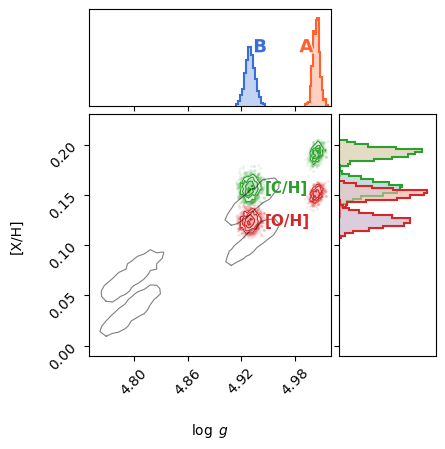

A,C/H 0.3653571129981715
A,O/H 0.3844087899885853

B,C/H 0.11208676523928497
B,O/H 0.12263517657656905


In [13]:
#posterior_ranges = [(4.975,5.02),(0.12,0.21)]; bins = 35
#posterior_ranges = [(4.902,5.02),(0.10,0.205)]; bins = 50
posterior_ranges = [(4.6,5.0),(0.,0.16)]; bins = 15
#labels = [r'$\log\ g$', r'$[\mathrm{C/H}]$ or $[\mathrm{O/H}]$']
labels = [r'$\log\ g$', r'[X/H]']

corner_kwargs = dict(
    bins=bins, 
    #range=posterior_ranges, 
    
    fill_contours=True, 
    plot_datapoints=True, 
    
    labels=labels, 
    #show_titles=True, 
    use_math_text=True, 
    title_fmt='.2f', 
    title_kwargs={'fontsize':10},#, 'loc':'left', 'x':0.05}, 
    #labelpad=0.03, 
    labelpad=-0.03, 
    
    #smooth=True, 
)

fig = plt.figure(figsize=(4.5,4.5))
for key, color_i in zip(['C/H', 'O/H'], [color_species['12CO'], color_species['H2O']]):
#for key, color_i in zip(['C/H', 'O/H', '(C+O)/H'], [color_species['12CO'], color_species['H2O'], 'k']):

    cmap = mpl.colors.LinearSegmentedColormap.from_list('', ['w',color_i])
    env_colors = cmap([0,1/4,2/4,3/4,1])
    env_colors[:,3] = 0.5; env_colors[0,3] = 0.0

    corner_kwargs['color'] = color_i
    corner_kwargs['hist_kwargs'] = {
        'edgecolor':color_i, 'facecolor':env_colors[1], 'fill':True, 'density':True, 'lw':1.5, 
        }
    corner_kwargs['contourf_kwargs'] = {'colors':env_colors}
    corner_kwargs['contour_kwargs']  = {'linewidths':0.8, 'colors':color_i}

    fig = corner.corner(
        fig=fig, 
        data=np.array([log_g_A,abs_abund_A[key][:,0]]).T, 
        **corner_kwargs
    )
    fig = corner.corner(
        fig=fig, 
        data=np.array([log_g_B,abs_abund_B[key][:,0]]).T, 
        **corner_kwargs
    )

# Reshape the axes to a square matrix
ax = np.array(fig.axes)
ax = ax.reshape((int(np.sqrt(len(ax))), int(np.sqrt(len(ax)))))

xlim = (4.75,5.02); ylim = (-0.01,0.23)
ax[0,0].set(xlim=xlim)
ax[1,0].set(xlim=xlim, ylim=ylim)
ax[1,1].set(xlim=ylim)

q = np.array([
    0.5-0.997/2, 0.5-0.95/2, 0.5-0.68/2, 0.5, 
    0.5+0.68/2, 0.5+0.95/2, 0.5+0.997/2
    ])

ann_kwargs = dict(
    xycoords=ax[0,0].get_xaxis_transform(), 
    ha='center', va='top', c=color_m_A, fontsize=13, fontweight='bold', 
    path_effects=[pe.withStroke(linewidth=2, foreground='w', alpha=0.8)]
)
ax[0,0].annotate(
    'A', xy=(np.median(log_g_A)-3*np.std(log_g_A),0.7), **ann_kwargs
    )
ann_kwargs['c'] = color_m_B
ax[0,0].annotate(
    'B', xy=(np.median(log_g_B)+2*np.std(log_g_B),0.7), **ann_kwargs
    )

for i, patch_i in enumerate(list(ax[0,0].patches)):
    patch_i.set_facecolor('none')
    patch_i.set_edgecolor('none')
    if i == 0:
        patch_i.set_facecolor(env_colors_m_A[1])
        patch_i.set_edgecolor(color_m_A)
    elif i == 1:
        patch_i.set_facecolor(env_colors_m_B[1])
        patch_i.set_edgecolor(color_m_B)

# Rotate the axis and apply height/width ratios
for i, patch_i in enumerate(list(ax[1,1].patches)):
    patch_i.set_xy(np.array([patch_i.xy[:,1],patch_i.xy[:,0]]).T)

xlim, ylim = ax[1,1].get_xlim(), ax[1,1].get_ylim()
ax[1,1].set(yticks=ax[1,1].get_xticks(), xticks=ax[1,1].get_yticks())
ax[1,1].set(ylim=xlim, xlim=ylim, xlabel=None)


hist_kwargs = corner_kwargs['hist_kwargs']
hist_kwargs['zorder'] = -1

hist_kwargs['edgecolor'] = 'none'
hist_kwargs['facecolor'] = env_colors_m_A[1]
ax[1,1].hist(abs_abund_A['C/H'][:,0], bins=bins, orientation='horizontal', **hist_kwargs)
ax[1,1].hist(abs_abund_A['O/H'][:,0], bins=bins, orientation='horizontal', **hist_kwargs)

hist_kwargs['facecolor'] = env_colors_m_B[1]
ax[1,1].hist(abs_abund_B['C/H'][:,0], bins=bins, orientation='horizontal', **hist_kwargs)
ax[1,1].hist(abs_abund_B['O/H'][:,0], bins=bins, orientation='horizontal', **hist_kwargs)

'''
xy_CH = (
    np.median(log_g_A)-5*np.std(log_g_A), 
    np.median(abs_abund_A['C/H'][:,0])+1*np.std(abs_abund_A['C/H'][:,0]), 
)
xy_OH = (
    np.median(log_g_A)+0*np.std(log_g_A), 
    np.median(abs_abund_A['O/H'][:,0])-3*np.std(abs_abund_A['O/H'][:,0]), 
)
'''
xy_CH = (np.median(log_g_B)+3*np.std(log_g_B), np.median(abs_abund_B['C/H'][:,0]))
xy_OH = (np.median(log_g_B)+3*np.std(log_g_B), np.median(abs_abund_B['O/H'][:,0]))
iterables = zip(
    (xy_CH,xy_OH), (color_species['12CO'],color_species['H2O']), ('[C/H]','[O/H]')
    )

for i, vert_i in enumerate([*vertices_A_CH,*vertices_A_OH,*vertices_B_CH,*vertices_B_OH]):
    if i % 3 != 0:
        continue
    ax[1,0].plot(*vert_i.T, c='k', lw=0.8, alpha=0.5)

for xy_i, color_i, label_i in iterables:
    ax[1,0].annotate(
        label_i, xy=xy_i, color=color_i, ha='left', va='center', 
        fontsize=11, fontweight='bold'
        )

gs = ax[0,0].get_gridspec()
gs.set_height_ratios([1,2.5]); gs.set_width_ratios([2.5,1], )
gs.update()

plt.subplots_adjust(left=0.2, bottom=0.2, right=0.97, top=0.97)
#plt.subplots_adjust(left=0.1, bottom=0.1, right=0.45, top=0.97)
#plt.savefig('./plots/K_band_log_g_metallicity.pdf')
plt.show()

from scipy.stats import pearsonr

iterables = zip(
    [log_g_A,log_g_A,log_g_B,log_g_B], 
    [abs_abund_A['C/H'][:,0],abs_abund_A['O/H'][:,0],abs_abund_B['C/H'][:,0],abs_abund_B['O/H'][:,0]], 
    ['A,C/H','A,O/H','\nB,C/H','B,O/H']
)
for log_g_i, abund_i, label_i in iterables:
    print(label_i, pearsonr(log_g_i, abund_i).statistic)

In [16]:
def save_contours(x, y, filename='./log_g_metallicity_contours/A_CH.pkl'):

    fig = plt.figure(figsize=(5,5))
    fig = corner.corner(
        fig=fig, data=np.array([x,y]).T, **corner_kwargs
    )
    ax = np.array(fig.axes)
    ax = ax.reshape((int(np.sqrt(len(ax))), int(np.sqrt(len(ax)))))
    contours = ax[1,0].collections[6:9]
    plt.close(fig)

    vertices = []
    for cs in contours:
        p = cs.get_paths()[0]
        vertices.append(p.vertices)

    import pickle
    with open(filename, 'wb') as fp:
        pickle.dump(vertices, fp)

save_contours(log_g_A, abs_abund_A['C/H'][:,0], filename='./log_g_metallicity_contours/A_CH.pkl')
save_contours(log_g_A, abs_abund_A['O/H'][:,0], filename='./log_g_metallicity_contours/A_OH.pkl')

save_contours(log_g_B, abs_abund_B['C/H'][:,0], filename='./log_g_metallicity_contours/B_CH.pkl')
save_contours(log_g_B, abs_abund_B['O/H'][:,0], filename='./log_g_metallicity_contours/B_OH.pkl')